In [1]:
if False:
  !echo "Downloading Data Base"
  !wget https://navee-public.s3-eu-west-1.amazonaws.com/20170509-bam-2.2m-Nja9G.sqlite.bz2
  !bzip2 -d 20170509-bam-2.2m-Nja9G.sqlite.bz2
  !mv 20170509-bam-2.2m-Nja9G.sqlite data.sqlite

**Defining the classes and Functions to return the classes**

In [2]:
classes = {0: 'content_building', 1:'emotion_happy', 2:'content_flower',
                    3:'content_bicycle', 4:'media_comic', 5:'content_people',
                    6:'media_3d_graph',7:'content_dog',8:'media_vectorart',9:'emotion_scary',
                    10:'emotion_gloom', 11: 'media_graphite', 12: 'emotion_peaceful', 13: 'media_pen_ink',
                    14:'content_cars', 15:'media_oilpaint', 16: 'content_cat', 17: 'content_tree', 18: 'content_bird',19:'media_watercolor'}
list_classes = [classes[i] for i in range(20)]
list_content = []
list_emotion = []
list_media = []
for i in list_classes:
  if(i[:7] == 'content'):
    list_content.append(i)
  elif(i[:7] == 'emotion'):
    list_emotion.append(i)
  else:
    list_media.append(i)

print(list_content)

def return_class(res):
  cls = []
  for i in range(len(res)):
    if(res[i]>0.55):
      cls.append(classes[i])
  
  return cls



['content_building', 'content_flower', 'content_bicycle', 'content_people', 'content_dog', 'content_cars', 'content_cat', 'content_tree', 'content_bird']


In [46]:
import sys
sys.path.append('../')
sys.path.append('../data/')
sys.path.append('../LSHash')

In [4]:
import numpy as np
from Data_Gen import DataGenerator
from data import *

Using TensorFlow backend.


In [5]:
import matplotlib.pyplot as plt
from keras.regularizers import l2

<h1>Creating the Keras model:<h1/>

**Importing the modules needed**

In [6]:


from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization

Defining the model, in here we used a pre-trained ResNet 50 with the Imagenet database to extract the pricipal features of the images

In [7]:
model = Sequential()
model.add(ResNet50(include_top = False,weights = 'imagenet'))
model.add(Dropout(0.2))
model.add(Conv2D(1024,3,activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu',kernel_regularizer= l2(0.1), bias_regularizer=l2(0.1)))
model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(20,activation = 'sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 2048)  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 1024)  18875392  
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 1024)  4096      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)            

In [8]:
#model.layers[0].summary()

In here we define which layers we train, in this case we're going to train the 10 last layers of the ResNet

In [9]:
model.layers[0].trainable = True
for i in model.layers[0].layers:
  i.trainable = False

for i in range(10):
  model.layers[0].layers[-i].trainable = True

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<h1>Loading dataset<h1/>

**In here the module data and Data_Gen created will be used to help loading the model**

1. First we will create a function that take a PIL.Image object and convert to a vector of shape (224,224,3) and preprocess to use in ResNet

In [10]:
def preprocess(x):
    x = x.convert('RGB')
    x = x.resize((224,224))
    x = np.array(x)
    return preprocess_input(x)

2. Now we are going to take the Images ID's that are going to be used to train and test the model

In [11]:
ptest = 0.3

In [12]:
db = data_base('../data/data.sqlite')
# Datasets
IDs = db.get_images(3000)
labels = {i:db.get_label(i) for i in IDs}


In [13]:
dados = {}
for i in ['media', 'content', 'emotions']:
  dados[i] = []


In [14]:
partition = {}
partition['train'] = IDs[:int((1-ptest)*len(IDs))]
partition['test'] = IDs[int((1-ptest)*len(IDs)):len(IDs)]

print(len(partition['test'])/len(IDs))


0.3


3. Creating Generator to make for efficient memory use ( It is a array that loads the data only when there's a request for the data )

In [15]:
train_generator = DataGenerator(partition['train'], content_l+media_l+emotions_l,db=db, pre = preprocess)
validation_generator = DataGenerator(partition['test'], content_l+media_l+emotions_l, db = db,pre = preprocess)

In [16]:
proportion = {classes[i]:0 for i in classes}
for i in labels.keys():
  for j in return_class(labels[i]):
    proportion[j] = proportion[j]+1

for i in proportion:
  print(i, ": ",proportion[i]/len(labels)*100,"%")

media_oilpaint :  5.773710482529118 %
emotion_happy :  6.56405990016639 %
content_people :  20.424292845257906 %
media_3d_graph :  5.599001663893511 %
content_dog :  5.449251247920133 %
content_cat :  5.341098169717138 %
content_flower :  6.430948419301165 %
content_bird :  5.973377703826955 %
emotion_peaceful :  10.324459234608984 %
content_tree :  8.826955074875208 %
media_comic :  9.10981697171381 %
media_graphite :  5.607321131447588 %
emotion_gloom :  6.314475873544093 %
media_watercolor :  5.915141430948419 %
content_building :  6.8885191347753745 %
emotion_scary :  5.773710482529118 %
content_cars :  7.454242928452579 %
media_pen_ink :  6.322795341098169 %
media_vectorart :  5.840266222961731 %
content_bicycle :  5.898502495840266 %


4. Showing the format of some images and how the generator works

In [17]:
a = train_generator[3][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


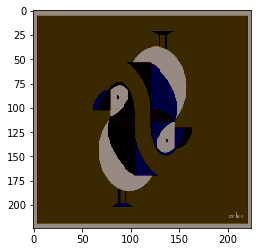

In [18]:
def show_im(a):
  plt.imshow(a/255)
  plt.show()
show_im(a[0])

5. Making a prediction with some images (OBS the model is not trained yet, it's just to understand how it will work)

In [19]:
res = model.predict(a)

In [20]:
res[0]

array([0.3703636 , 0.87132394, 0.23465863, 0.60478985, 0.5660674 ,
       0.37368876, 0.21635652, 0.39279553, 0.6060294 , 0.2850213 ,
       0.7036556 , 0.20447087, 0.45269543, 0.40502882, 0.92913973,
       0.662605  , 0.5173594 , 0.6551863 , 0.61969346, 0.75654805],
      dtype=float32)

<h1>Training the Model<h1/>

In [22]:
#model.fit_generator(train_generator,steps_per_epoch=train_generator.__len__(),
#                          validation_data = validation_generator,
#                          validation_steps = validation_generator.__len__(), epochs=10, verbose=True, shuffle=True)

In [23]:

j=11
c = train_generator[j]

<h1> Testing the Model</h1>

In [32]:
i = 7
#url = 'https://media2.carredartistes.com/us/17934-thickbox_default/unique-contemporary-artwork-agusil-happy.jpg'
#img = load_image(url=url)
#b = preprocess(img)
#a = np.expand_dims(b,axis=0)
a = np.expand_dims(c[0][i],axis=0)
b = c[0][i]
certo = c[1][i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


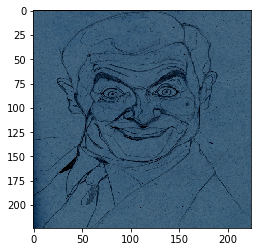

In [33]:
res = model.predict(a)
show_im(b)

In [34]:
print(res)
return_class(res[0])

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9808013e-01 0.0000000e+00
  0.0000000e+00 5.5432320e-06 0.0000000e+00 0.0000000e+00 5.2988529e-05
  0.0000000e+00 0.0000000e+00 9.9988568e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


['content_bicycle', 'emotion_peaceful']

In [35]:
return_class(certo)

['emotion_peaceful']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


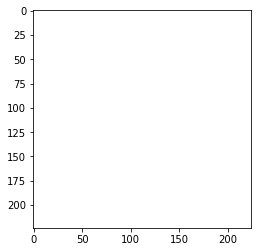

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


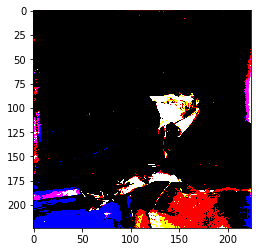

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


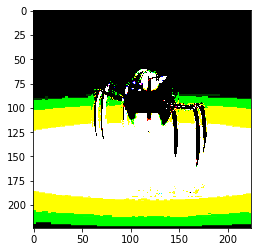

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


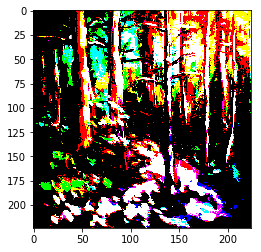

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


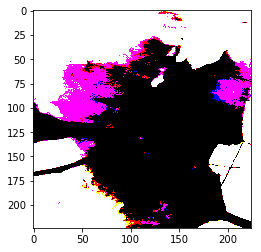

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


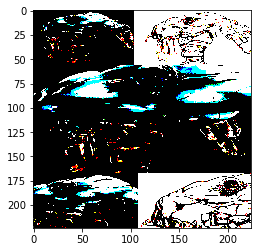

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


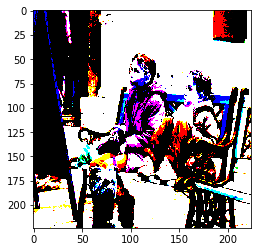

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


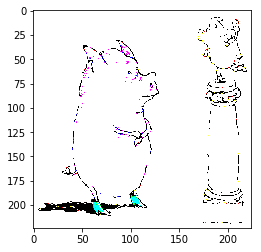

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


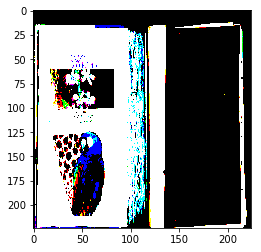

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


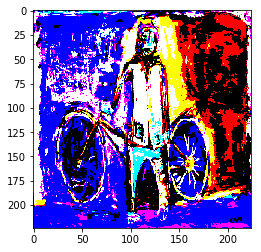

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


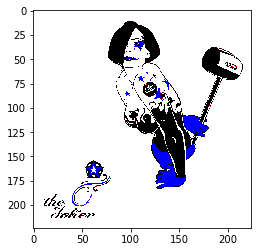

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


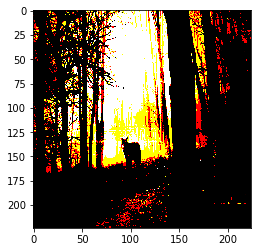

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


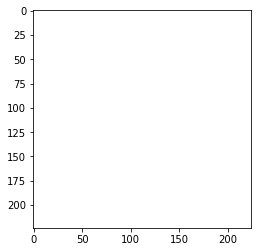

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


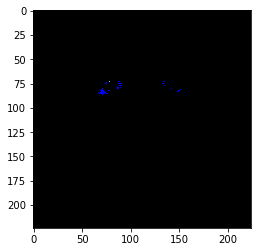

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


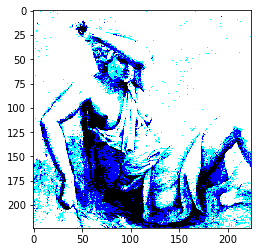

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


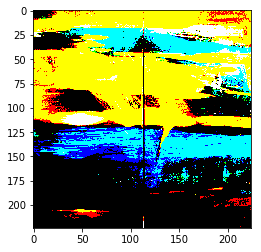

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


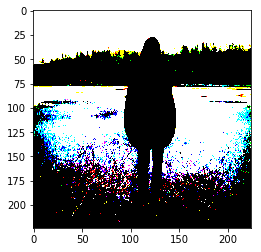

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


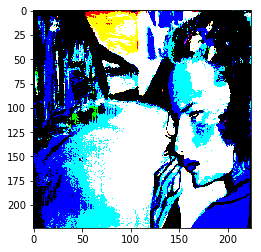

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


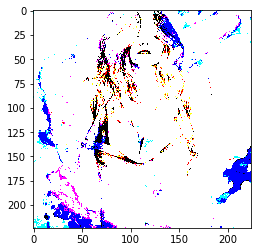

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


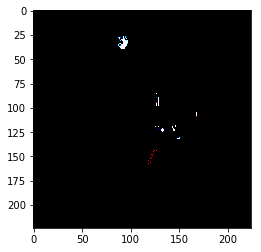

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


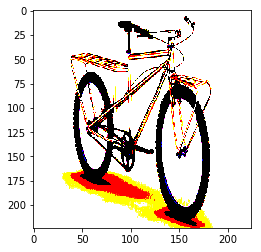

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


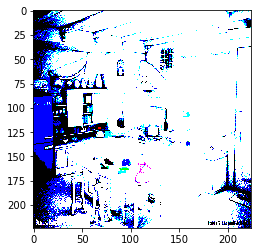

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


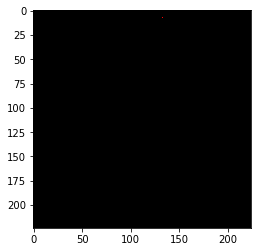

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


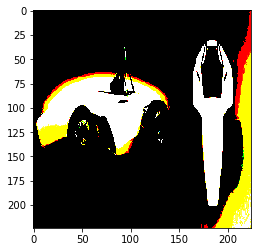

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


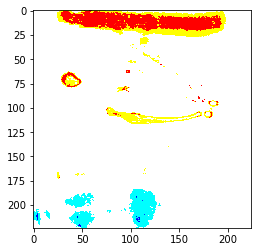

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


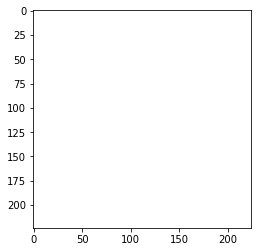

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


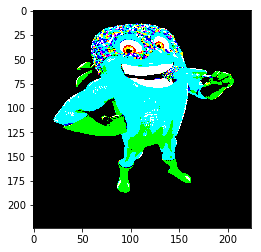

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


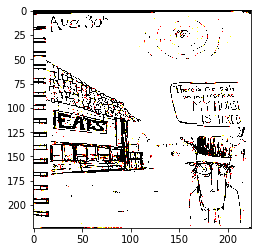

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


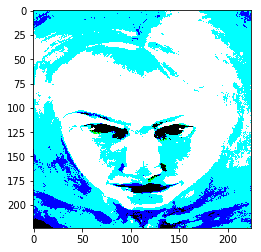

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


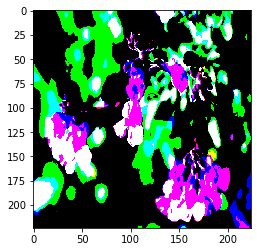

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


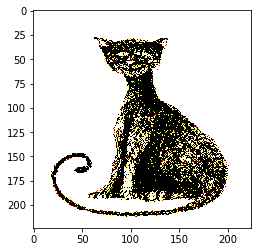

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


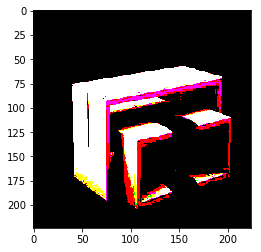

In [36]:
for i in train_generator[0][0]:
  print(i.shape)
  plt.imshow(i)
  plt.show()
  

In [37]:
train_generator[0][0][2]

array([[[-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        ...,
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031]],

       [[-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        ...,
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031]],

       [[-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        ...,
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031],
        [-40.93900299, -31.77899933, -63.68000031]],

       ...,

      

<h1>Evauating the Model</h1>

In [39]:
model.evaluate_generator(validation_generator)

<h1> Saving the Model </h1>

In [40]:
from feature_extractor import *

In [41]:
save_model_json(model,model_path='./',model_name='model_90_256')

<h1>Creating the model to transform the image in the Feature Vector</h1>

In here our feature vector will be generated when entering the image in the classifier and the feature vector is the result of the last layer

In [48]:
fe = Model(input=model.input, output = model.layers[-2].output)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("re..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [49]:
res = fe.predict(a)

In [50]:
len(res[0])

256

In [51]:
def dist(a,b):
  a = np.array(a)
  b = np.array(b)
  c = np.power(a-b,2)
  return c.sum()
dist([0,0],[1,2])

5

Here, we're going to use the LSHash library to reduce timing comparing the features vectors

In [53]:
from lshash import LSHash 
import pickle

k = 10 # hash size
L = 5  # number of tables
d = 256 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)# LSH on all the images



def train():
    for i in IDs:
        url = db.get_image(i)
        vect = load_image(url)
        #vect.show()
        vect = preprocess(vect)
        vect = np.expand_dims(vect,axis = 0)
        
        vect = ok.predict(vect)[0]
        lsh.index(vect,extra_data=url)
#train()
#pickle.dump(lsh, open('lsh2.p', "wb"))
#lsh = pickle.load(open('../LSHash/lsh.p', "rb"))
  

In [54]:
'''from google.colab import files
files.download('lsh2.p')'''

"from google.colab import files\nfiles.download('lsh2.p')"

In [55]:
from PIL import Image
def get_similar_item(img, lsh_variable, n_items=5,url = False):
    if(url):
        img = load_image(img)
        img = preprocess(img)
        img = np.expand_dims(img,axis = 0)
        
    vect = ok.predict(img)[0]
    #print(vect)
    response = lsh_variable.query(vect, 
                     num_results=n_items+1, distance_func='euclidean')
    
    return response

In [56]:
i = 28
j = 6
img_ = validation_generator[i][0][j]
img = np.expand_dims(img_,axis = 0)
#img = train_generator[i][0][j]
label = validation_generator[i][1][j]
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1200px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'
res = get_similar_item(url,lsh,url=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


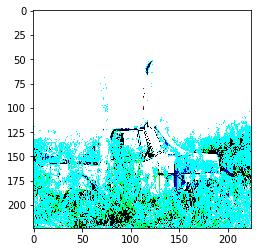

In [57]:
plt.imshow(img_)
plt.show()
for i in res:
    im = load_image(i[0][1])
    im = im.convert('RGB')
    im = im.resize((224,224))
    im = np.array(im)

    plt.imshow(im)
    plt.show()
    #print(i[0][0])

In [58]:
test_generator = DataGenerator(partition['test'][:1000], content_l+media_l+emotions_l, db = db,pre = preprocess)

In [60]:
model.evaluate_generator(test_generator)